In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**1. Import các thư viện cần thiết**

In [ ]:
# 1. Các thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression

**2. Đọc file dữ liệu VPB và chia dataset theo tỉ lệ 7:2:1**

In [ ]:
# Đọc file dữ liệu
df = pd.read_csv('/content/drive/MyDrive/StockData/VPB.csv')
df = df[['Price']]
df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index

# Split the data into training, testing, and validation
train_size = int(0.7 * len(df))
test_size = int(0.2 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

**Xem** **lại** **dataset**

In [ ]:
df

,Price
0,10676.9
1,10687.7
2,10698.5
3,11195.6
4,11498.2
...,...
1246,19450.0
1247,19300.0
1248,19400.0
1249,19850.0


**3. Dùng model ARIMA để train data**

In [ ]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 20.6 MB/s eta 0:00:00


In [ ]:
# Quá trình Training
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Price'])
# Find the best ARIMA model using auto_arima
from pmdarima.arima import auto_arima
model = auto_arima(y_train, trace=True, error_action='ignore', suppress_warnings=True, seasonal = False)
# Fit the model
model.fit(y_train)

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=2.97 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=12854.352, Time=0.04 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=12633.333, Time=0.09 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.37 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=12852.360, Time=0.02 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=12571.713, Time=0.14 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=12544.999, Time=0.23 sec
 ARIMA(4,2,0)(0,0,0)[0] intercept   : AIC=12493.235, Time=0.29 sec
 ARIMA(5,2,0)(0,0,0)[0] intercept   : AIC=12483.504, Time=0.41 sec
 ARIMA(5,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=2.16 sec
 ARIMA(4,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=1.75 sec
 ARIMA(5,2,0)(0,0,0)[0]             : AIC=12481.501, Time=0.18 sec
 ARIMA(4,2,0)(0,0,0)[0]             : AIC=12491.234, Time=0.13 sec
 ARIMA(5,2,1)(0,0,0)[0]             : AIC=inf, Time=1.40 sec
 ARIMA(4,2,1)(0,0,0)[0]             : AIC=inf, Ti

ARIMA(order=(5, 2, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

**4. Quá trình test**

In [ ]:
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Price'])
y_pred = model.predict(n_periods=len(y_test))


**5. Quá trình validate**

In [ ]:
x_val= np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data['Price'])
y_pred_val =  model.predict(n_periods=len(y_val))

**6. Quá trình tạo index predict 30 ngày tiếp theo**

In [ ]:
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

# Create an array of 30 consecutive integers starting from last_index
x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)

# Predict the closing prices for the next 30 days
y_next_30_days = model.predict(n_periods=len(x_next_30_days))

# Print the predicted closing prices for the next 30 days
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

Predicted closing prices for the next 30 days:
[26646.84479864 27039.03962634 27492.03730256 27993.45382405
 28531.6778166  29067.60001686 29561.93779063 30050.17055941
 30547.06857028 31053.63482487 31565.047736   32071.48787648
 32573.16586917 33074.72874029 33578.03290241 34083.06718047
 34588.1455395  35092.22543814 35595.77031199 36099.42232207
 36603.44443986 37107.67546951 37611.81688074 38115.79936848
 38619.72673015 39123.69834176 39627.73322395 40131.78390209
 40635.81025726 41139.81332378]


***7.Đánh giá độ chính xác thuật toán***

In [ ]:
#RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - y_val)**2))
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)

#MAPE
valid_mape = np.mean(np.abs((y_val - y_pred_val) / y_val)) * 100
test_mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
print('Validation MAPE:', valid_mape)
print('Testing MAPE:', test_mape)

#MAE
valid_mae = np.mean(np.abs(y_pred_val - y_val))
test_mae = np.mean(np.abs(y_pred - y_test))
print('Validation MAE:', valid_mae)
print('Testing MAE:', test_mae)

Validation RMSE: 42891.48583705971
Testing RMSE: 78651.86034473329
Validation MAPE: 204.4860121840508
Testing MAPE: 358.77529354049284
Validation MAE: 39149.47247243146
Testing MAE: 68277.79657293421


**8. Vẽ biểu đồ**

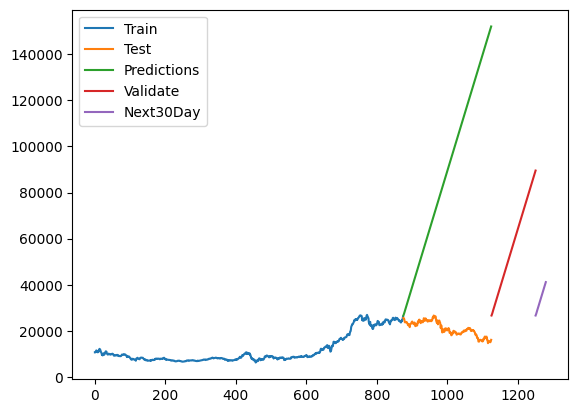

In [ ]:
plt.plot(train_data.index, train_data['Price'])
plt.plot(test_data.index, test_data['Price'])
plt.plot(test_data.index, y_pred)
plt.plot(val_data.index, y_pred_val)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Predictions','Validate','Next30Day'])
plt.show()